<h1>Crimes in LA</h1>

In [1]:
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from datetime import datetime
from pprint import pprint
from IPython.display import display
from IPython.display import HTML
import pandas as pd
import ipywidgets as widgets
import folium, re

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
Click <a href="javascript:code_toggle()">here</a> to view code''')

In [2]:
#Crimes_2012-2015
#https://catalog.data.gov/dataset/crimes-2012-2015

# 935259 Rows
# 2012 - 2015
#Header = Date.Rptd, DR.NO,DATE.OCC,TIME.OCC,AREA,AREA.NAME,RD,Crm.Cd,CrmCd.Desc,Status,Status.Desc,
#            LOCATION,Cross.Street,Location.1
#AREA.NAME = districten

years =[]

#import dataset (pas locatie aan)
#filter header eruit
crime_data = (sc.textFile('../data/crimesLA/Crimes_2012-2015.csv').filter(lambda line: 'DATE.OCC' not in line))

year12 = crime_data.filter(lambda line: '/2012'  in line)
year13 = crime_data.filter(lambda line: '/2013'  in line)
year14 = crime_data.filter(lambda line: '/2014'  in line)
year15 = crime_data.filter(lambda line: '/2015'  in line)

years.append(year12)
years.append(year13)
years.append(year14)
years.append(year15)

In [3]:
x_axis = range(2012,2016)
y_axis = []

for i in range(0, 4):
    y_axis.append(years[i].count())
#     print years[i].count()

<h1>Crimes per year</h1>

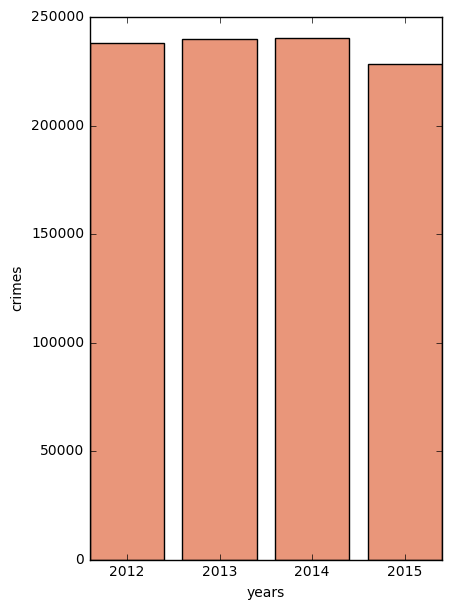

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(122)
ax.set_xlabel('years')
ax.set_ylabel('crimes')
my_xticks = ['2012', '2013', '2014', '2015']
plt.xticks(x_axis, my_xticks)
# ax.get_xaxis().get_major_formatter().set_useOffset(False)
ax.bar(x_axis, y_axis, fc='darksalmon', align='center')
plt.show()

<h1>Slider split for each year, split per crime</h1>
<h3>Personal Crimes</h3>
<p>“Offenses against the Person”: These are crimes that result in physical or mental harm to another person.</p>
<h3>Property Crimes</h3>
<p>“Offenses against Property”: These are crimes that do not necessarily involve harm to another person. Instead, they involve an interference with another person’s right to use or enjoy their property.</p>
<h3>Inchoate Crimes</h3>
<p>“Inchoate” translates into “incomplete”, meaning crimes that were begun, but not completed. This requires that a person take a substantial step to complete a crime, as opposed to just “intend” to commit a crime.</p>
<h3>Statutory Crimes</h3>
<p>A violation of a specific state or federal statute and can involve either property offenses or personal offense.</p>

In [5]:
personCrimesid = [952,231,230,624,622,623,860,840,870,235,627,813,237,922,812,110,930,943,753,886,434,111,830,940,236,626,
                763,250,251,821,845,810,815,850,910,882,884,435,820,933,625,888,756,113,121,932,762]
propertyCrimesid = [648,480,487,942,949,662,664,310,330,654,653,660,951,950,345,444,668,670,349,347,924,331,420,354,440,473,474,350,341,647,470,471,740,745,510,442,
                    343,430,431,446,352,805,661,210,351,931]
inchoateCrimesid = [220,485,761,666,320,410,944,954,445,421,450,441,475,520,443,920,452,436,451,122,928,930]
statutoryCrimesid = [948,755,903,880,649,652,651,433,865,353,439,900,901,902,806,437,438,956,946,814,822]
trafficCrimesid = [997,890]

def parse_interaction(line):
    elems = line.split(",")
    crimeId = int(elems[7])
    if crimeId in personCrimesid:
        return ("personCrimes", elems)
    elif crimeId in propertyCrimesid:
        return ("propertyCrimes", elems)
    elif crimeId in inchoateCrimesid:
        return ("inchoateCrimes", elems)
    elif crimeId in statutoryCrimesid:
        return ("statutoryCrimes", elems)
    elif crimeId in trafficCrimesid:
        return ("trafficCrimes", elems)
    else:
        return ("None", None)
    
def select_year(year):
    if year==2012:
        key_crimes_data = year12.map(parse_interaction)
        return key_crimes_data
    elif year==2013:
        key_crimes_data = year13.map(parse_interaction)
        return key_crimes_data
    elif year==2014:
        key_crimes_data = year14.map(parse_interaction)
        return key_crimes_data
    elif year==2015:
        key_crimes_data = year15.map(parse_interaction)
        return key_crimes_data
    else:
        print year

# person_crimes_data = key_crimes_data.filter(lambda x: x[0]=="personCrimes")
# print person_crimes_data.take(5)
# Geeft alle data weer van personCrimes
# [('personCrimes', [u'12/31/2012', u'120101612', u'12/31/2012', u'2250', u'1', u'Central', u'156', u'230', u'"ASSAULT WITH DEADLY WEAPON', u' AGGRAVATED ASSAULT"', u'AA', u'Adult Arrest', u' WALL ST', u'5TH ST', u'"(34.0449', u' -118.2458)"'])]

# print key_crimes_data.countByKey()
# Geeft:
# defaultdict(<type 'int'>, {'traficCrimes': 37835, 'propertyCrimes': 128216, 'inchoateCrimes': 4740, 'personCrimes': 55543, 'statutoryCrimes': 11783})

In [6]:
form = """
<div style='background-color:gainsboro; border:solid black; width:300px; padding:20px;'>
Year : <input id='year' type='range' min='2012' max='2015' step='1' value='2012' onchange='set_vars()'/>
</div>
"""
javascript = """
<script type="text/Javascript">
    function set_vars(){
        var var_name1 = 'inp_year';
        var var_value1 = document.getElementById('year').value;
        var command1 = var_name1 + " = '" + var_value1 + "'";
        var kernel = IPython.notebook.kernel;
        kernel.execute(command1);
        cell = IPython.notebook.get_cell(9);
        cell.execute();
        cell.focus_cell();
    }
</script>
"""

key_crimes_data = select_year(2012)
inp_year = 2012
HTML(form + javascript)

In [14]:
key_crimes_data = select_year(int(inp_year))

<h1>Crimes per hour, split by category</h1>

In [15]:
person_crimes = key_crimes_data.filter(lambda x: x[0]=="personCrimes")
person_crimes_time = person_crimes.map(lambda x: int(x[1][3]) / 100)
# person_crimes_time.collect()

property_crimes = key_crimes_data.filter(lambda x: x[0]=="propertyCrimes")
property_crimes_time = property_crimes.map(lambda x: int(x[1][3]) / 100)

inchoate_crimes = key_crimes_data.filter(lambda x: x[0]=="inchoateCrimes")
inchoate_crimes_time = inchoate_crimes.map(lambda x: int(x[1][3]) / 100)

statutory_crimes = key_crimes_data.filter(lambda x: x[0]=="statutoryCrimes")
statutory_crimes_time = statutory_crimes.map(lambda x: int(x[1][3]) / 100)

traffic_crimes = key_crimes_data.filter(lambda x: x[0]=="trafficCrimes")
traffic_crimes_time = traffic_crimes.map(lambda x: int(x[1][3]) / 100)

personCrimes_time = pd.Series(person_crimes_time.collect()).value_counts().sort_index()
#print personCrimes_time
propertyCrimes_time = pd.Series(property_crimes_time.collect()).value_counts().sort_index()
inchoateCrimes_time = pd.Series(inchoate_crimes_time.collect()).value_counts().sort_index()
statutoryCrimes_time = pd.Series(statutory_crimes_time.collect()).value_counts().sort_index()
trafficCrimes_time = pd.Series(traffic_crimes_time.collect()).value_counts().sort_index()

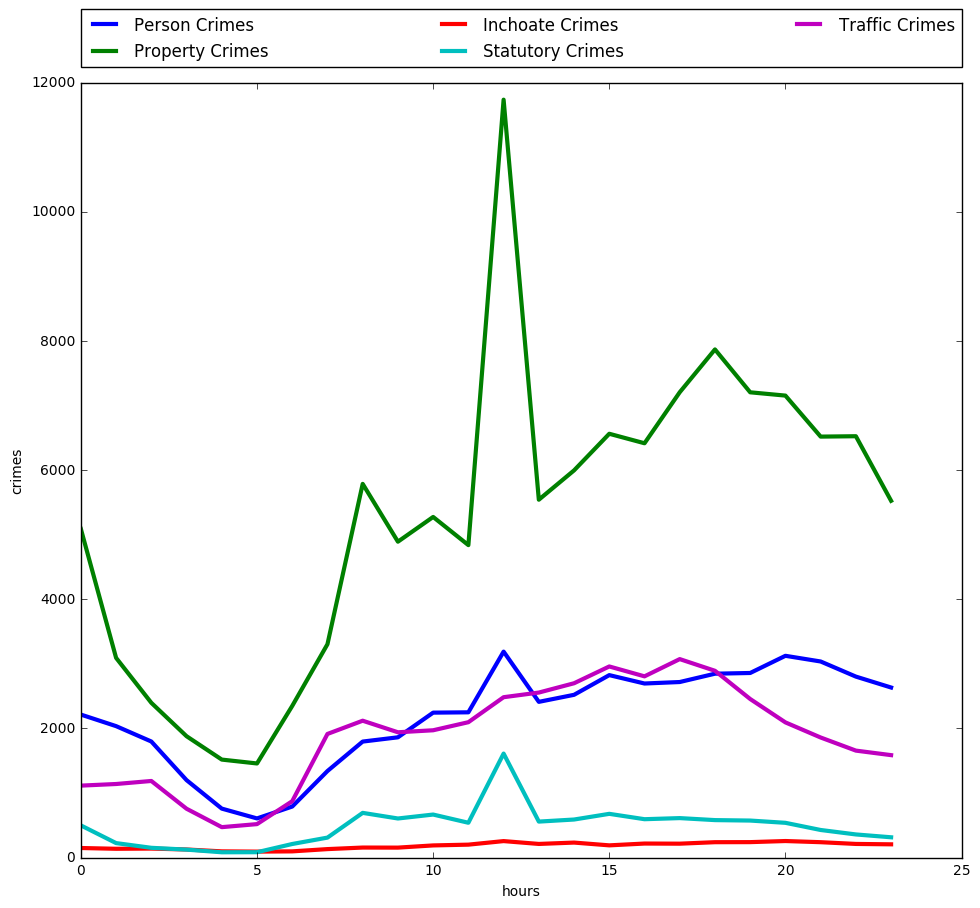

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt

try:
    fig = plt.figure(figsize=(25, 10))
except:
    pass

plt = fig.add_subplot(122)
plt.set_ylabel('crimes')
plt.set_xlabel('hours')
plt.plot(personCrimes_time, label='Person Crimes', linewidth=3)
plt.plot(propertyCrimes_time, label='Property Crimes', linewidth=3)
plt.plot(inchoateCrimes_time, label='Inchoate Crimes', linewidth=3)
plt.plot(statutoryCrimes_time, label='Statutory Crimes', linewidth=3)
plt.plot(trafficCrimes_time, label='Traffic Crimes', linewidth=3)
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=3, mode="expand", borderaxespad=0.)

pass

<h1>Crimes in 2012, split by category</h1>

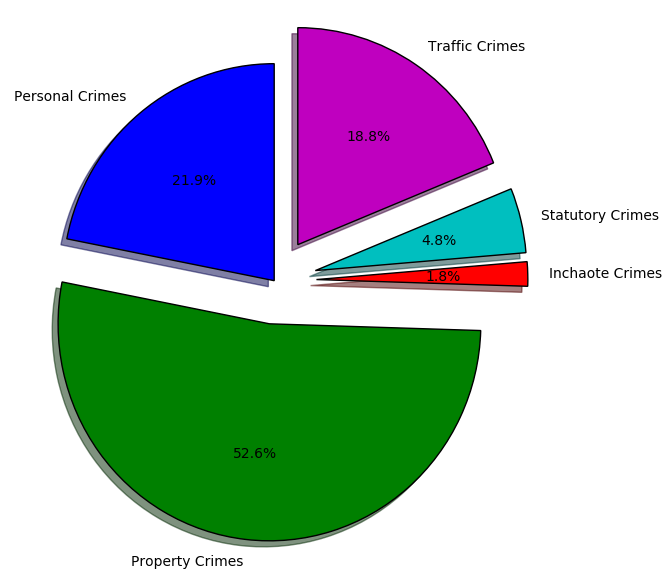

In [17]:
from pyspark.mllib.stat import Statistics
import matplotlib.pyplot as plt
%matplotlib inline

person_crimes_data = key_crimes_data.filter(lambda x: x[0]=="personCrimes")
property_crimes_data = key_crimes_data.filter(lambda x: x[0]=="propertyCrimes")
inchaote_crimes_data = key_crimes_data.filter(lambda x: x[0]=="inchoateCrimes")
statutory_crimes_data = key_crimes_data.filter(lambda x: x[0]=="statutoryCrimes")
trafic_crimes_data = key_crimes_data.filter(lambda x: x[0]=="trafficCrimes")

# http://karthik.github.io/2014-02-18-UTS/lessons/thw-matplotlib/tutorial.html
person_crimes_count = person_crimes_data.count()
property_crimes_count = property_crimes_data.count()
inchaote_crimes_count = inchaote_crimes_data.count()
statutory_crimes_count = statutory_crimes_data.count()
trafic_crimes_count = trafic_crimes_data.count()

labels = ['Personal Crimes', 'Property Crimes', 'Inchaote Crimes', 'Statutory Crimes', 'Traffic Crimes']
fracs = [person_crimes_count,property_crimes_count,inchaote_crimes_count,statutory_crimes_count, trafic_crimes_count]
explode = (0, 0.2, 0.2, 0.2, 0.2)

fig = plt.figure(figsize=(15, 7))
ax1 = fig.add_subplot(121)
ax1.pie(fracs, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
pass

In [11]:
# data_12 = select_year(2012)
# data_13 = select_year(2013)
# data_14 = select_year(2014)
# data_15 = select_year(2015)

# person_crimes_data_12 = data_12.filter(lambda x: x[0]=="personCrimes").count()
# property_crimes_data_12 = data_12.filter(lambda x: x[0]=="propertyCrimes").count()
# inchaote_crimes_data_12 = data_12.filter(lambda x: x[0]=="inchoateCrimes").count()
# statutory_crimes_data_12 = data_12.filter(lambda x: x[0]=="statutoryCrimes").count()
# trafic_crimes_data_12 = data_12.filter(lambda x: x[0]=="trafficCrimes").count()

# person_crimes_data_13 = data_13.filter(lambda x: x[0]=="personCrimes").count()
# property_crimes_data_13 = data_13.filter(lambda x: x[0]=="propertyCrimes").count()
# inchaote_crimes_data_13 = data_13.filter(lambda x: x[0]=="inchoateCrimes").count()
# statutory_crimes_data_13 = data_13.filter(lambda x: x[0]=="statutoryCrimes").count()
# trafic_crimes_data_13 = data_13.filter(lambda x: x[0]=="trafficCrimes").count()

# person_crimes_data_14 = data_14.filter(lambda x: x[0]=="personCrimes").count()
# property_crimes_data_14 = data_14.filter(lambda x: x[0]=="propertyCrimes").count()
# inchaote_crimes_data_14 = data_14.filter(lambda x: x[0]=="inchoateCrimes").count()
# statutory_crimes_data_14 = data_14.filter(lambda x: x[0]=="statutoryCrimes").count()
# trafic_crimes_data_14 = data_14.filter(lambda x: x[0]=="trafficCrimes").count()

# person_crimes_data_15 = data_15.filter(lambda x: x[0]=="personCrimes").count()
# property_crimes_data_15 = data_15.filter(lambda x: x[0]=="propertyCrimes").count()
# inchaote_crimes_data_15 = data_15.filter(lambda x: x[0]=="inchoateCrimes").count()
# statutory_crimes_data_15 = data_15.filter(lambda x: x[0]=="statutoryCrimes").count()
# trafic_crimes_data_15 = data_15.filter(lambda x: x[0]=="trafficCrimes").count()

In [12]:
# import matplotlib.pyplot as plt
# %matplotlib inline

# labels1 = ['Personal Crimes12', 'Personal Crimes13', 'Personal Crimes14','Personal Crimes15']
# fracs1 = [person_crimes_data_12, person_crimes_data_13, person_crimes_data_14, person_crimes_data_15]
# explode = (0, 0, 0, 0)

# fig1 = plt.figure(figsize=(15, 7))
# fig1.suptitle('Crimes in 2012', fontsize=14, fontweight='bold')
# ax1 = fig1.add_subplot(121)
# ax1.pie(fracs1, explode=explode, labels=labels1, autopct='%1.1f%%', shadow=True, startangle=90)

# labels2 = ['inchaote 12', 'inchaote 13', 'inchaote 14', 'inchaote 15']
# # fracs2 = [property_crimes_data_12, property_crimes_data_13, property_crimes_data_14, property_crimes_data_15]


# explode = (0, 0, 0, 0)

# fig2 = plt.figure(figsize=(15, 7))
# fig2.suptitle('Crimes in 2012', fontsize=14, fontweight='bold')
# ax2 = fig2.add_subplot(121)
# ax2.pie(fracs2, explode=explode, labels=labels2, autopct='%1.1f%%', shadow=True, startangle=90)

# fracs2 = [inchaote_crimes_data_12, inchaote_crimes_data_13, inchaote_crimes_data_14, inchaote_crimes_data_15]
# fracs4 = [statutory_crimes_data_12, statutory_crimes_data_13, statutory_crimes_data_14, statutory_crimes_data_15]
# fracs5 = [trafic_crimes_data_12, trafic_crimes_data_13, trafic_crimes_data_14, trafic_crimes_data_15]

<h1>Crimes on a map</h1>

In [13]:
crimes = ["personCrimes", "propertyCrimes", "inchoateCrimes", "statutoryCrimes", "trafficCrimes"]

map_view = folium.Map(location=[34.0592, -118.3351], zoom_start=11)

def parse_coords(line):
    line_lenght = len(line[1])
    try:
        lat_coord = re.sub('[\"\(\) ]', '', line[1][line_lenght-2])
        long_coord = re.sub('[\"\(\) ]', '', line[1][line_lenght-1])
        return (float(lat_coord), float(long_coord))
    except:
        return (None, None)

for crime in crimes:
    try:
        crime_data = key_crimes_data.filter(lambda x: x[0]==crime)
        crime_data_coords = crime_data.map(parse_coords)
        
        if crime=="personCrimes":
            c = "blue"
            p = "Person crime"
        elif crime=="propertyCrimes":
            c = "green"
            p = "Property crime"
        elif crime=="inchoateCrimes":
            c = "cyan"
            p = "Inchoate crime"
        elif crime=="statutoryCrimes":
            c = "yellow"
            p = "Statutory crime"
        elif crime=="trafficCrimes":
            c = "magenta"
            p = "Traffic crime"
        else:
            c = "red"
            p = "None"
    
        r = 1
        for coords in crime_data_coords.distinct().take(100):
            map_view.circle_marker(location=[coords[0], coords[1]], radius=r, popup=p, line_color=c, fill_color=c)
    except:
        pass

# Prints the map
map_view

C:\Users\Xiemas\Anaconda2\lib\site-packages\ipykernel\__main__.py:40: FutureWarning: circle_marker is deprecated. Use add_children(CircleMarker) instead
